# Data Science for Spatial Systems

# Weather's Impact on Taxi Trip Duration in Chicago

*Word Count:*                      *1995*

*Estimated Running Time:*                        *30 mins*

# 1. Introduction

As the impact of weather on transportation has gained increasing attention in recent years, cities must understand weather's influence on travel behavior to develop effective transportation policies and manage traffic congestion, air pollution, and climate change (Koetse and Rietveld, 2009). In particular, the taxi industry, which plays a vital role in urban transportation systems, is highly sensitive to weather variability (Kamga, Yazici and Singhal, 2013). Chicago, as the third-most populous city in the United States and a major transportation hub, faces unique challenges in managing its taxi system under various weather conditions (Changnon, 1996).

Understanding the factors influencing taxi trip duration is crucial for optimizing taxi fleet management, reducing passenger wait times, and mitigating traffic congestion. Weather conditions, such as precipitation intensity, wind speed, and visibility constraints, have been identified as key variables affecting both taxi trip duration and overall traffic speeds (Chmielewski and Budzynski, 2019; Sakhare et al., 2023; Zhang et al., 2018). However, the extent to which weather impacts taxi trip duration varies across different geographical contexts. Chicago's diverse weather patterns due to its continental climate make it an ideal case study for studying weather's complex impact on taxi trip duration.

Several studies have specifically focused on the impact of weather on taxi trip speed and duration. Zhang et al., (2018) explored how different intensities of rainfall affect road travel speeds across various urban road types in Beijing, showing that heavier rain significantly reduces travel speeds, with more pronounced reductions during peak traffic hours. Similarly, Sakhare et al., (2023) investigated the impact of varying rain intensities on interstate traffic speeds using connected vehicle data, finding that very heavy rain reduces average speeds by about 8.4% compared to no rain. Recent studies have employed more advanced machine learning algorithms to model the relationship between weather and taxi trip duration. Poongodi et al., (2022) found the XGBoost model outperforms Multi-Layer Perceptron models in predicting taxi trip durations and prices in New York City.

This study employs machine learning techniques to investigate weather's impact on taxi trip duration in Chicago. By focusing on Chicago, this research contributes to a better understanding of how weather affects taxi travel time in a major U.S. city with unique weather challenges. Moreover, by comparing the performance of linear regression, ElasticNet regression, Random Forest, and XGBOOST models, this study aims to identify the most effective approach for modeling the relationship between weather and taxi trip duration in Chicago. To accelerate the computation of ElasticNet regression and Random Forest models, we utilize NVIDIA's RAPIDS framework for GPU acceleration, which enables high-performance data science (Learn More | RAPIDS, no date).


# 2. Research Question

RQ1: What are the key weather variables influencing taxi trip duration in Chicago?

RQ2：Among linear regression, ElasticNet regression, Random Forest, and XGBoost models, which one performs the best in predicting taxi trip duration in Chicago?

# 3. Presentation of Data

## 3.1 Data Collection and Explanation

### 3.1.1 Data Collection

Our Taxi Trips Chicago data comes from [Kaggle](https://www.kaggle.com/datasets/adelanseur/taxi-trips-chicago-2024) and provides data on all taxi trips within Chicago from January 1 to March 1, 2024. To protect privacy, the latitude and longitude in the data have been anonymized to the center of the pickup census tract or the community area.

The Weather data comes from [Visual Crossing](https://www.visualcrossing.com/). It allows us to obtain an hourly weather data for Chicago, including a variety of weather-related variables.

### 3.1.2 Variable Descriptions for Chicago Taxi Trip and Weather Dataset

We will only show the variables related to our research.

#### Trip Information
- **Trip_ID**: Unique identifier for each trip
- **Taxi_ID**: Unique identifier for each taxi
- **Trip_Start_Timestamp**: Timestamp of the trip start time
- **Trip_End_Timestamp**: Timestamp of the trip end time
- **Trip_Seconds**: Duration of the trip in seconds
- **Trip_Miles**: Distance of the trip in miles
- **Pickup_Community_Area**: Community area number where the trip started
- **Dropoff_Community_Area**: Community area number where the trip ended

#### Fare Information
- **Fare**: Base fare for the trip
- **Tips**: Tips paid by the passenger
- **Tolls**: Tolls incurred during the trip
- **Extras**: Additional fees or charges
- **Trip_Total**: Total cost of the trip
- **Payment_Type**: Payment method used by the passenger
- **Company**: Taxi company that provided the service

#### Derived Variables
- **days_from_base**: Number of days from the base date to the trip date (calculated in data processing)
- **hour**: Hour of the day when the trip started (0-23) (extracted in data processing)

#### Weather Data
- **temp**: Temperature in Fahrenheit
- **feelslike**: Feels like temperature in Fahrenheit
- **dew**: Dew point temperature in Fahrenheit
- **humidity**: Relative humidity in percentage
- **precip**: Precipitation
- **snow**: Snowfall in inches
- **snowdepth**: Snow depth in inches
- **windgust**: Wind gust speed in miles per hour
- **windspeed**: Average wind speed in miles per hour
- **winddir**: Wind direction in degrees
- **sealevelpressure**: Sea level pressure in millibars
- **cloudcover**: Cloud cover percentage
- **visibility**: Visibility in miles
- **solarradiation**: Solar radiation in watts per square meter
- **solarenergy**: Solar energy in megajoules per square meter
- **uvindex**: UV index

## 3.2 Data Preprocessing

### 3.2.1 Environment Configuration and Data Loading

Our analysis uses GPU-accelerated machine learning, please confirm that you have configured the following environment and installed the required libraries.

Environment requirements:
- [CUDA 12.4](https://developer.nvidia.com/cuda-downloads)
- [Python 3.11.8](https://www.python.org/downloads/release/python-3118/)
- [Ubuntu 22.04](https://ubuntu.com/download/desktop)
- [Windows 11](https://www.microsoft.com/software-download/windows11)

Suit of Libraries
- [RAPIDS 24.04](https://rapids.ai/)

In [4]:
# package import
%load_ext cudf.pandas  
# pandas API is now automatically GPU accelerated

import pandas as pd
import numpy as np
import cupy as cp
import cudf
import cuml
from cuml.model_selection import train_test_split, GridSearchCV
from cuml.linear_model import ElasticNet
from cuml.metrics import r2_score, mean_squared_error
from cuml.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split as sk_train_test_split
from sklearn.model_selection import GridSearchCV as sk_GridSearchCV
from sklearn.ensemble import RandomForestRegressor as sklRandomForestRegressor

from xgboost import XGBRegressor

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

The cudf.pandas extension is already loaded. To reload it, use:
  %reload_ext cudf.pandas


In [5]:
# url of weather dataset
url_weather = 'https://github.com/MengyuanHan1/Data-Science-for-Spatial-Systems/raw/main/Chicago%202024-01-01%20to%202024-03-01.csv'

# Load the taxi data, please see as attached
taxi = pd.read_csv('Taxi_Trips_-_2024_20240408.csv')
# Load the second CSV file
weather = pd.read_csv(url_weather)

In [6]:
# Check taxi data
taxi.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Extras,Trip Total,Payment Type,Company,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location
0,0287f53fedcde6b0af9aab9e32cbd2cadb337eaa,e54db25f18193a08f1f5754515e8c338480e04fb938ed3...,03/01/2024 12:00:00 AM,03/01/2024 12:00:00 AM,15,0.09,NaN,NaN,8,8.0,...,35.0,38.75,Credit Card,City Service,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
1,1f0034299b914fd7b45002568576a353c83acb2f,4a263f78f56815be4acd38658af8fc1824ce4e15f7ec81...,03/01/2024 12:00:00 AM,03/01/2024 12:15:00 AM,900,3.00,NaN,NaN,24,8.0,...,0.0,12.00,Cash,Taxi Affiliation Services,41.901207,-87.676356,POINT (-87.6763559892 41.9012069941),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
2,01a0b77b722a0b91f45cb4fc90b3e64f76fd0681,4f1e94982e6851725add382f7981d64006ae7c38f3664f...,03/01/2024 12:00:00 AM,03/01/2024 12:00:00 AM,711,5.84,NaN,NaN,56,NaN,...,5.0,26.70,Credit Card,City Service,41.792592,-87.769615,POINT (-87.7696154528 41.7925923603),NaN,NaN,None
3,14aff2071ac81c6450a8f8b0e1534497da900197,de8e8659ceb9eb0da842a46b60c0a5207098ac69fc23ab...,03/01/2024 12:00:00 AM,03/01/2024 12:30:00 AM,1770,13.36,NaN,NaN,76,3.0,...,4.0,47.10,Credit Card,Sun Taxi,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),41.965812,-87.655879,POINT (-87.6558787862 41.96581197)
4,16d3a633e2f380cee4a7fa4677db163b6e91255d,d79d3e19a1d5f6cb0cd4449d5579412262a2f1b182799d...,03/01/2024 12:00:00 AM,03/01/2024 12:15:00 AM,849,6.13,NaN,NaN,8,3.0,...,0.0,22.82,Mobile,5 Star Taxi,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.965812,-87.655879,POINT (-87.6558787862 41.96581197)


In [7]:
# Check weather data
weather.head()

,name,datetime,temp,feelslike,dew,humidity,precip,precipprob,preciptype,snow,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,Chicago,2024-01-01T00:00:00,0.8,-5.1,-2.9,76.79,0.0,0,None,0.0,...,1021.1,100.0,16.0,0,0.0,0,10,Overcast,cloudy,"72534014819,KORD,KMDW,72530094846,F1983,744665..."
1,Chicago,2024-01-01T01:00:00,0.8,-4.6,-3.0,76.14,0.0,0,None,0.0,...,1021.7,100.0,16.0,0,0.0,0,10,Overcast,cloudy,"72534014819,KORD,KMDW,72530094846,F1983,744665..."
2,Chicago,2024-01-01T02:00:00,0.8,-4.6,-3.0,76.14,0.0,0,None,0.0,...,1022.5,100.0,13.6,0,0.0,0,10,Overcast,cloudy,"72534014819,KORD,KMDW,72530094846,F1983,744665..."
3,Chicago,2024-01-01T03:00:00,0.4,-4.5,-2.5,80.46,0.0,0,None,0.0,...,1023.1,100.0,12.7,0,0.0,0,10,Overcast,cloudy,"72534014819,KORD,KMDW,72530094846,F1983,744665..."
4,Chicago,2024-01-01T04:00:00,0.2,-5.4,-3.1,78.50,0.0,0,None,0.0,...,1023.6,100.0,14.7,0,0.0,0,10,Overcast,cloudy,"72534014819,KORD,KMDW,72530094846,F1983,744665..."


### 3.2.2 Data Cleaning and Wrangling

#### Spaces in columns

Before further investigation, we need to clean the spaces in column names.

In [8]:
# Clean the spaces in the columns and replace them with _
taxi.columns = taxi.columns.str.replace(' ', '_')
taxi.head()

,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,Extras,Trip_Total,Payment_Type,Company,Pickup_Centroid_Latitude,Pickup_Centroid_Longitude,Pickup_Centroid_Location,Dropoff_Centroid_Latitude,Dropoff_Centroid_Longitude,Dropoff_Centroid__Location
0,0287f53fedcde6b0af9aab9e32cbd2cadb337eaa,e54db25f18193a08f1f5754515e8c338480e04fb938ed3...,03/01/2024 12:00:00 AM,03/01/2024 12:00:00 AM,15,0.09,NaN,NaN,8,8.0,...,35.0,38.75,Credit Card,City Service,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
1,1f0034299b914fd7b45002568576a353c83acb2f,4a263f78f56815be4acd38658af8fc1824ce4e15f7ec81...,03/01/2024 12:00:00 AM,03/01/2024 12:15:00 AM,900,3.00,NaN,NaN,24,8.0,...,0.0,12.00,Cash,Taxi Affiliation Services,41.901207,-87.676356,POINT (-87.6763559892 41.9012069941),41.899602,-87.633308,POINT (-87.6333080367 41.899602111)
2,01a0b77b722a0b91f45cb4fc90b3e64f76fd0681,4f1e94982e6851725add382f7981d64006ae7c38f3664f...,03/01/2024 12:00:00 AM,03/01/2024 12:00:00 AM,711,5.84,NaN,NaN,56,NaN,...,5.0,26.70,Credit Card,City Service,41.792592,-87.769615,POINT (-87.7696154528 41.7925923603),NaN,NaN,None
3,14aff2071ac81c6450a8f8b0e1534497da900197,de8e8659ceb9eb0da842a46b60c0a5207098ac69fc23ab...,03/01/2024 12:00:00 AM,03/01/2024 12:30:00 AM,1770,13.36,NaN,NaN,76,3.0,...,4.0,47.10,Credit Card,Sun Taxi,41.980264,-87.913625,POINT (-87.913624596 41.9802643146),41.965812,-87.655879,POINT (-87.6558787862 41.96581197)
4,16d3a633e2f380cee4a7fa4677db163b6e91255d,d79d3e19a1d5f6cb0cd4449d5579412262a2f1b182799d...,03/01/2024 12:00:00 AM,03/01/2024 12:15:00 AM,849,6.13,NaN,NaN,8,3.0,...,0.0,22.82,Mobile,5 Star Taxi,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.965812,-87.655879,POINT (-87.6558787862 41.96581197)


#### Timestamps

The timestamps of the taxi and weather datasets are different, wrangle them to align and merge with timestamps.

In [9]:
# Wrangle Timestamps

taxi['Trip_Start_Timestamp'] = pd.to_datetime(taxi['Trip_Start_Timestamp'])
weather['datetime'] = pd.to_datetime(weather['datetime'])

# Create a benchmark date (2024-01-01)
base_date = pd.to_datetime('2024-01-01')

# Due to significant variations in Trip Seconds, we will use Trip_Start_Timestamp for alignment with weather data, ignoring Trip_End_Timestamp

# Calculate the number of days between each date-time and the benchmark date
taxi['days_from_base'] = (taxi['Trip_Start_Timestamp'] - base_date).dt.days
weather['days_from_base'] = (weather['datetime'] - base_date).dt.days

# Round the date-time down to the nearest whole hour for aligning time to the hourly level later
taxi['rounded_hour'] = taxi['Trip_Start_Timestamp'].dt.floor('h')
taxi['hour'] = taxi['rounded_hour'].dt.hour

weather['rounded_hour'] = weather['datetime'].dt.floor('h')
weather['hour'] = weather['rounded_hour'].dt.hour

/home/jax/miniconda3/envs/rapids-24.04/lib/python3.11/site-packages/cudf/pandas/fast_slow_proxy.py:30: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return fn(*args, **kwargs)


In [10]:
# Merge the two datasets and check
 
data = taxi.merge(weather, on=['days_from_base', 'hour'])

data.head()

,Trip_ID,Taxi_ID,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Census_Tract,Dropoff_Census_Tract,Pickup_Community_Area,Dropoff_Community_Area,...,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations,rounded_hour_y
0,0287f53fedcde6b0af9aab9e32cbd2cadb337eaa,e54db25f18193a08f1f5754515e8c338480e04fb938ed3...,2024-03-01,03/01/2024 12:00:00 AM,15,0.09,NaN,NaN,8,8.0,...,0.0,16.0,0,0.0,0,10,Clear,clear-night,"72534014819,KORD,KMDW,72530094846,F1983,744665...",2024-03-01
1,1f0034299b914fd7b45002568576a353c83acb2f,4a263f78f56815be4acd38658af8fc1824ce4e15f7ec81...,2024-03-01,03/01/2024 12:15:00 AM,900,3.00,NaN,NaN,24,8.0,...,0.0,16.0,0,0.0,0,10,Clear,clear-night,"72534014819,KORD,KMDW,72530094846,F1983,744665...",2024-03-01
2,01a0b77b722a0b91f45cb4fc90b3e64f76fd0681,4f1e94982e6851725add382f7981d64006ae7c38f3664f...,2024-03-01,03/01/2024 12:00:00 AM,711,5.84,NaN,NaN,56,NaN,...,0.0,16.0,0,0.0,0,10,Clear,clear-night,"72534014819,KORD,KMDW,72530094846,F1983,744665...",2024-03-01
3,14aff2071ac81c6450a8f8b0e1534497da900197,de8e8659ceb9eb0da842a46b60c0a5207098ac69fc23ab...,2024-03-01,03/01/2024 12:30:00 AM,1770,13.36,NaN,NaN,76,3.0,...,0.0,16.0,0,0.0,0,10,Clear,clear-night,"72534014819,KORD,KMDW,72530094846,F1983,744665...",2024-03-01
4,16d3a633e2f380cee4a7fa4677db163b6e91255d,d79d3e19a1d5f6cb0cd4449d5579412262a2f1b182799d...,2024-03-01,03/01/2024 12:15:00 AM,849,6.13,NaN,NaN,8,3.0,...,0.0,16.0,0,0.0,0,10,Clear,clear-night,"72534014819,KORD,KMDW,72530094846,F1983,744665...",2024-03-01


#### NAs

We need to confirm that the columns related to our research contain no NAs to avoid errors, and remove any that are found.

In [11]:
data.isnull().sum()

Trip_ID                            0
Taxi_ID                            1
Trip_Start_Timestamp               0
Trip_End_Timestamp                 8
Trip_Seconds                     169
Trip_Miles                         6
Pickup_Census_Tract           537996
Dropoff_Census_Tract          551393
Pickup_Community_Area          23195
Dropoff_Community_Area         83853
Fare                            2045
Tips                            2045
Tolls                           2045
Extras                          2045
Trip_Total                      2045
Payment_Type                       0
Company                            0
Pickup_Centroid_Latitude       22966
Pickup_Centroid_Longitude      22966
Pickup_Centroid_Location       22966
Dropoff_Centroid_Latitude      79675
Dropoff_Centroid_Longitude     79675
Dropoff_Centroid__Location     79675
days_from_base                     0
rounded_hour_x                     0
hour                               0
name                               0
d

In [12]:
# Focus on variables which has nulls and related to our research, drop all the NAs

columns_to_drop = [
    'Taxi_ID', 'Trip_Start_Timestamp', 'Trip_End_Timestamp',
    'Trip_Seconds', 'Trip_Miles', 'Pickup_Community_Area',
    'Dropoff_Community_Area', 'Fare', 'Tips', 'Tolls', 'Extras',
    'Trip_Total'
]

# Delete NAs in columns_to_drop
data = data.dropna(subset=columns_to_drop)

In [13]:
# Rearrange the data, select colunms related to our research and data cleaning

# Select the columns of interest
columns_of_interest = [
    'Trip_ID', 'Taxi_ID', 'Trip_Start_Timestamp', 'Trip_End_Timestamp',
    'Trip_Seconds', 'Trip_Miles', 'Pickup_Community_Area',
    'Dropoff_Community_Area', 'Fare', 'Tips', 'Tolls', 'Extras',
    'Trip_Total', 'Payment_Type', 'Company', 'days_from_base', 
    'hour', 'temp', 'feelslike', 'dew', 'humidity',
    'precip', 'snow', 'snowdepth', 'windgust',
    'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
    'solarradiation', 'solarenergy', 'uvindex'
]

# Filter data based on columns_of_interest
data = data[columns_of_interest]

# Calculate the NAs
data.isnull().sum()


Trip_ID                   0
Taxi_ID                   0
Trip_Start_Timestamp      0
Trip_End_Timestamp        0
Trip_Seconds              0
Trip_Miles                0
Pickup_Community_Area     0
Dropoff_Community_Area    0
Fare                      0
Tips                      0
Tolls                     0
Extras                    0
Trip_Total                0
Payment_Type              0
Company                   0
days_from_base            0
hour                      0
temp                      0
feelslike                 0
dew                       0
humidity                  0
precip                    0
snow                      0
snowdepth                 0
windgust                  0
windspeed                 0
winddir                   0
sealevelpressure          0
cloudcover                0
visibility                0
solarradiation            0
solarenergy               0
uvindex                   0
dtype: int64

Now We have removed all null values from the columns of interest and retained only these columns for further analysis.

### 3.3.3 Exploratory Data Analysis

We will conduct a further exploration of the data, include analysing individual variables and considering multiple variables. We will also identify and exclude outliers based on the practical significance of the variables.

In [14]:
# To clearly display results, we defined this function to hide the output of Trip_ID and Taxi_ID columns in some cases

def simple_print_head(df, ignore_columns=['Trip_ID', 'Taxi_ID'], n=5):
    """
    Prints the DataFrame, excluding specified columns by default.
    
    Parameters:
    df : DataFrame
        Pandas DataFrame to be printed.
    ignore_columns : list, optional
        List of columns to be ignored, defaults to 'Trip_ID' and 'Taxi_ID'.
    n : int, optional
        Number of rows to be printed, defaults to 5.
    """
    
    # Calculate columns to be printed
    columns_to_print = [col for col in df.columns if col not in ignore_columns]
    
    # Print the DataFrame with specified number of rows, including only selected columns
    return df[columns_to_print].head(n)



#### Trip Miles

In [15]:
# Sort the 'Trip_Miles' column in descending order
trip_miles_sorted = data.sort_values('Trip_Miles', ascending=False)

# Print the sorted DataFrame
simple_print_head(trip_miles_sorted, n=10)

,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Community_Area,Dropoff_Community_Area,Fare,Tips,Tolls,Extras,...,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex
305972,2024-02-10 10:00:00,02/10/2024 05:45:00 PM,27853,3093.47,8,76,9999.75,0.0,0.0,0.0,...,0.0,27.7,15.4,318,1015.9,92.8,16.0,119,0.4,1
830273,2024-01-03 21:00:00,01/03/2024 09:00:00 PM,0,664.90,76,76,41.25,0.0,0.0,4.0,...,0.0,25.9,14.3,322,1021.6,100.0,16.0,0,0.0,0
553835,2024-01-24 10:30:00,01/24/2024 11:00:00 AM,1788,493.03,56,28,32.00,7.3,0.0,4.0,...,0.0,11.2,10.6,61,1021.3,100.0,5.9,26,0.1,0
613434,2024-01-20 17:45:00,01/20/2024 05:45:00 PM,60,244.20,57,57,8.85,0.0,0.0,0.0,...,0.0,20.5,16.4,289,1036.4,24.2,16.0,0,0.0,0
313016,2024-02-09 17:00:00,02/09/2024 05:15:00 PM,840,241.30,28,21,14.75,0.0,0.0,0.0,...,0.0,35.3,19.9,245,1007.7,24.2,16.0,7,0.0,0
786156,2024-01-07 19:45:00,01/07/2024 08:15:00 PM,1380,159.00,76,7,39.50,8.8,0.0,4.0,...,0.0,16.6,2.8,322,1020.8,100.0,16.0,0,0.0,0
737407,2024-01-11 10:00:00,01/11/2024 03:00:00 PM,18657,135.57,33,33,332.50,0.0,0.0,163.0,...,0.0,35.8,23.1,289,1009.1,100.0,16.0,86,0.3,1
445367,2024-01-31 16:45:00,01/31/2024 08:15:00 PM,12769,132.12,76,6,0.05,0.0,0.0,0.0,...,0.0,37.1,24.9,228,1019.1,97.5,16.0,32,0.1,0
720852,2024-01-12 11:45:00,01/12/2024 03:00:00 PM,11479,115.38,76,75,0.05,0.0,0.0,0.0,...,0.0,46.7,30.2,101,994.8,100.0,2.4,9,0.0,0
629335,2024-01-19 15:00:00,01/19/2024 06:00:00 PM,10953,114.21,76,15,266.75,0.0,0.0,103.0,...,2.6,38.9,25.5,299,1026.2,89.0,16.0,30,0.1,0


In [16]:
# Sort the 'Trip_Miles' column in ascending order
trip_miles_sorted = data.sort_values('Trip_Miles', ascending=True)

# Print the sorted DataFrame
simple_print_head(trip_miles_sorted, n=10)

,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Community_Area,Dropoff_Community_Area,Fare,Tips,Tolls,Extras,...,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex
11,2024-03-01 00:00:00,03/01/2024 12:00:00 AM,180,0.0,24,7,11.25,0.00,0.0,0.0,...,0.0,34.8,21.1,191,1025.3,0.0,16.0,0,0.0,0
35,2024-03-01 00:00:00,03/01/2024 12:30:00 AM,1860,0.0,76,3,34.75,8.95,0.0,4.0,...,0.0,34.8,21.1,191,1025.3,0.0,16.0,0,0.0,0
40,2024-02-29 23:45:00,02/29/2024 11:45:00 PM,6,0.0,8,8,8.00,2.00,0.0,0.0,...,0.0,36.5,22.4,188,1025.8,0.0,16.0,0,0.0,0
45,2024-02-29 23:45:00,02/29/2024 11:45:00 PM,13,0.0,8,8,3.25,0.00,0.0,0.0,...,0.0,36.5,22.4,188,1025.8,0.0,16.0,0,0.0,0
50,2024-02-29 23:45:00,02/29/2024 11:45:00 PM,2,0.0,6,6,40.00,0.00,0.0,0.0,...,0.0,36.5,22.4,188,1025.8,0.0,16.0,0,0.0,0
52,2024-02-29 23:45:00,02/29/2024 11:45:00 PM,12,0.0,76,76,3.25,0.00,0.0,0.0,...,0.0,36.5,22.4,188,1025.8,0.0,16.0,0,0.0,0
53,2024-02-29 23:45:00,02/29/2024 11:45:00 PM,9,0.0,24,24,18.00,3.70,0.0,0.0,...,0.0,36.5,22.4,188,1025.8,0.0,16.0,0,0.0,0
66,2024-02-29 23:45:00,02/29/2024 11:45:00 PM,0,0.0,32,32,35.00,7.10,0.0,0.0,...,0.0,36.5,22.4,188,1025.8,0.0,16.0,0,0.0,0
95,2024-02-29 23:45:00,02/29/2024 11:45:00 PM,7,0.0,28,28,55.00,5.00,0.0,0.0,...,0.0,36.5,22.4,188,1025.8,0.0,16.0,0,0.0,0
118,2024-02-29 23:45:00,02/29/2024 11:45:00 PM,0,0.0,76,76,3.25,0.00,0.0,4.5,...,0.0,36.5,22.4,188,1025.8,0.0,16.0,0,0.0,0


We found some very large Trip_Miles and many zeros, so we set up filtering conditions accordingly.

In [17]:
# Apply filtering conditions: Select rows where Trip_Miles is greater than 0 and less than 40
data = data[(data['Trip_Miles'] > 0) & (data['Trip_Miles'] < 40)]

#### Trip Seconds

In [18]:
# Sort the 'Trip_Seconds' column in descending order
trip_seconds_sorted = data.sort_values('Trip_Seconds', ascending=False)

# Print the sorted DataFrame
simple_print_head(trip_seconds_sorted, n=10)

,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Community_Area,Dropoff_Community_Area,Fare,Tips,Tolls,Extras,...,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex
747312,2024-01-10 15:30:00,01/11/2024 03:30:00 PM,86135,2.42,2,2,38.75,0.0,0.0,0.0,...,0.0,32.2,14.8,223,1003.7,100.0,16.0,19,0.1,0
824294,2024-01-04 12:30:00,01/05/2024 11:45:00 AM,83900,5.95,4,28,83.75,0.0,0.0,0.0,...,0.0,9.4,4.8,70,1028.3,24.2,16.0,62,0.2,1
259933,2024-02-13 19:00:00,02/14/2024 06:15:00 PM,83697,5.15,32,7,15.50,0.0,0.0,0.0,...,0.0,9.4,6.2,316,1020.6,24.2,16.0,0,0.0,0
393282,2024-02-04 13:30:00,02/05/2024 12:15:00 PM,81322,15.30,32,49,76.25,0.0,0.0,0.0,...,0.0,27.7,17.7,42,1018.3,44.0,16.0,93,0.3,1
325325,2024-02-08 19:45:00,02/09/2024 06:00:00 PM,80244,1.62,16,17,9.75,2.0,0.0,0.0,...,0.0,55.5,20.0,162,1003.7,93.0,16.0,0,0.0,0
524038,2024-01-25 20:00:00,01/26/2024 06:15:00 PM,79418,22.52,7,21,69.75,0.0,0.0,0.0,...,0.0,16.6,19.1,43,1015.2,100.0,4.8,0,0.0,0
756644,2024-01-09 23:30:00,01/10/2024 09:15:00 PM,78165,35.50,6,28,113.00,0.0,0.0,0.0,...,0.0,50.2,25.7,319,986.2,100.0,5.0,0,0.0,0
603065,2024-01-21 14:45:00,01/22/2024 12:30:00 PM,78067,3.86,76,24,12.00,0.0,0.0,6.0,...,0.0,38.9,19.5,192,1034.2,78.4,16.0,144,0.5,1
54364,2024-02-26 23:45:00,02/27/2024 09:15:00 PM,77907,6.93,77,76,25.25,0.0,0.0,0.0,...,0.0,40.0,22.6,189,998.0,78.4,16.0,0,0.0,0
401663,2024-02-03 16:00:00,02/04/2024 01:45:00 PM,77901,3.94,7,24,14.50,0.0,0.0,0.0,...,0.0,16.6,18.1,63,1018.8,50.2,14.9,39,0.1,0


In [19]:
# Sort the 'Trip_Seconds' column in ascending order
trip_seconds_sorted = data.sort_values('Trip_Seconds', ascending=True)

# Print the sorted DataFrame
simple_print_head(trip_seconds_sorted, n=10)

,Trip_Start_Timestamp,Trip_End_Timestamp,Trip_Seconds,Trip_Miles,Pickup_Community_Area,Dropoff_Community_Area,Fare,Tips,Tolls,Extras,...,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex
514,2024-02-29 22:45:00,02/29/2024 10:45:00 PM,0,17.2,8,8,43.00,0.0,0.0,0.0,...,0.0,36.9,22.3,190,1026.3,0.0,16.0,0,0.0,0
962,2024-02-29 22:00:00,02/29/2024 10:00:00 PM,0,0.1,56,56,3.25,0.0,0.0,0.0,...,0.0,36.9,22.3,190,1026.3,0.0,16.0,0,0.0,0
1328,2024-02-29 21:30:00,02/29/2024 09:30:00 PM,0,1.5,41,41,7.25,0.0,0.0,1.0,...,0.0,36.6,20.5,188,1026.5,0.0,16.0,0,0.0,0
1571,2024-02-29 21:15:00,02/29/2024 09:15:00 PM,0,15.1,8,8,0.00,0.0,0.0,4.0,...,0.0,36.6,20.5,188,1026.5,0.0,16.0,0,0.0,0
1604,2024-02-29 21:00:00,02/29/2024 09:00:00 PM,0,8.1,42,42,22.50,0.0,0.0,0.0,...,0.0,36.6,20.5,188,1026.5,0.0,16.0,0,0.0,0
1677,2024-02-29 21:00:00,02/29/2024 09:00:00 PM,0,1.5,7,7,7.00,0.0,0.0,1.0,...,0.0,36.6,20.5,188,1026.5,0.0,16.0,0,0.0,0
2090,2024-02-29 20:30:00,02/29/2024 08:30:00 PM,0,0.1,51,51,3.25,0.0,0.0,0.0,...,0.0,38.9,20.7,188,1026.5,0.0,16.0,0,0.0,0
3967,2024-02-29 19:00:00,02/29/2024 07:00:00 PM,0,9.4,73,73,25.25,0.0,0.0,0.0,...,0.0,37.1,18.4,181,1026.7,0.0,16.0,0,0.0,0
4130,2024-02-29 18:45:00,02/29/2024 06:45:00 PM,0,0.4,8,8,4.75,1.0,0.0,0.0,...,0.0,43.1,20.2,198,1027.0,24.2,16.0,0,0.0,0
4228,2024-02-29 18:45:00,02/29/2024 06:45:00 PM,0,13.0,56,56,34.75,0.0,0.0,4.0,...,0.0,43.1,20.2,198,1027.0,24.2,16.0,0,0.0,0


We can see that there are some Trip Seconds that are extremely large, and many are zero. For those large ones, many of the Trip Miles are very short. Also, most orders occur at night. One speculation is that drivers might forget to turn off the meter until the next order ends or starts during their rest. Therefore, we have set up filtering conditions.

In [20]:
# Apply filtering conditions: Select rows where Trip_Seconds is greater than 0 and less than 10000
data = data[(data['Trip_Seconds'] > 0) & (data['Trip_Seconds'] < 10000)]

#### Average Speed

According to the regulations in Illinois [(Traffic and Safety, no date)](https://www.isp.illinois.gov/TrafficSafety/SpeedLimitEnforcement), the maximum speed limit within Chicago is 30 miles per hour. Therefore, we filter based on this criterion.

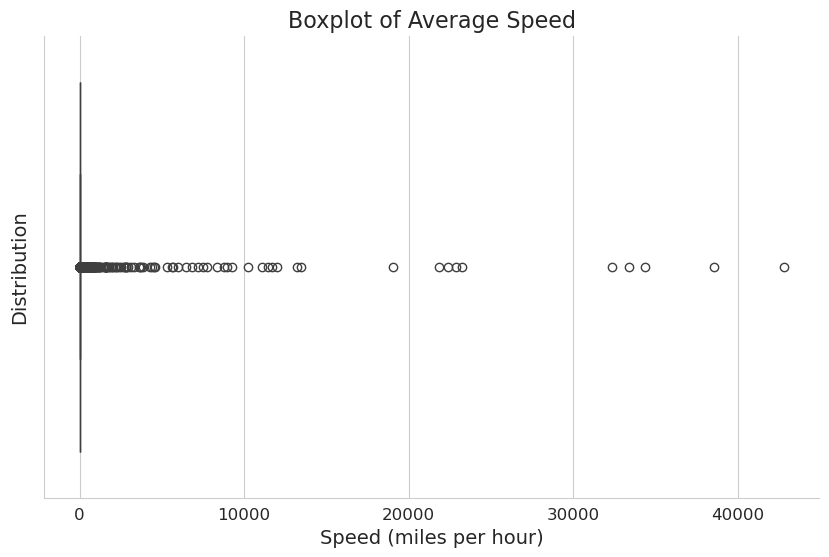

In [21]:
# Calculate average speed
data['Average_Speed'] = data['Trip_Miles'] / (data['Trip_Seconds'] / 3600)

# Set figure size and style
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

# Create boxplot
ax = sns.boxplot(x=data['Average_Speed'])

# Set labels and title
plt.title('Boxplot of Average Speed', fontsize=16)
plt.xlabel('Speed (miles per hour)', fontsize=14)
plt.ylabel('Distribution', fontsize=14)

# Remove top and right spines
sns.despine()

# Set tick label size
ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

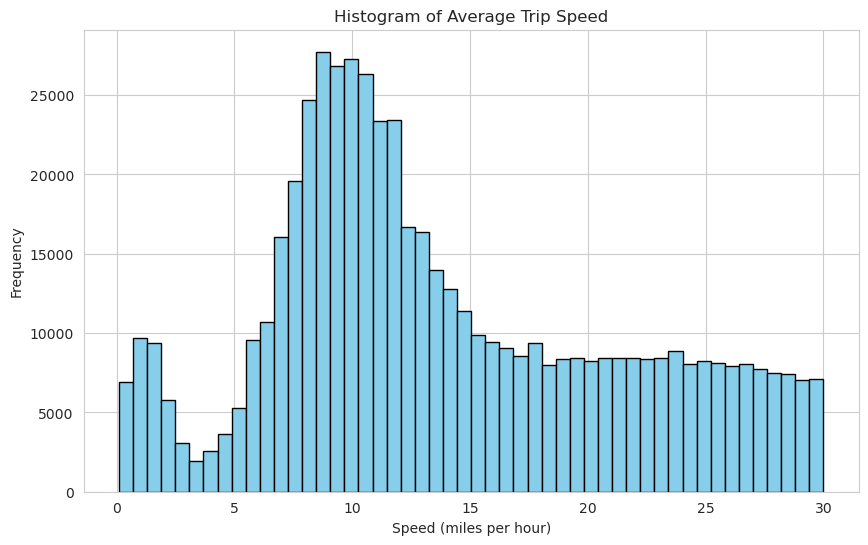

In [22]:
# Filter out rows where 'Trip_Seconds' and 'Trip_Miles' are 0, and average speed exceeds 30 or is less than 0.1
data = data[(data['Trip_Seconds'] != 0) & (data['Trip_Miles'] != 0) & (data['Average_Speed'] <= 30) & (data['Average_Speed'] >= 0.1)]

# Plot a histogram
plt.figure(figsize=(10, 6))
plt.hist(data['Average_Speed'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Average Trip Speed')
plt.xlabel('Speed (miles per hour)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

# Drop the 'Average_Speed' column as it is no longer needed
data.drop('Average_Speed', axis=1, inplace=True)

#### Trip Totals

According to the official Chicago Taxi fare [(‘chicagotaxiplacard20200629.pdf’, no date)](https://www.chicago.gov/content/dam/city/depts/bacp/publicvehicleinfo/Chicabs/chicagotaxiplacard20200629.pdf), the base fare is $3.25, and the cost per mile is $2.25. Therefore, we set up filtering conditions.

In [23]:
# Filter out rows where 'Trip_Total' is less than $3.25 and the cost per mile is less than $2.25
data = data[
    (data['Trip_Total'] >= 3.25) &
    ((data['Trip_Total'] / data['Trip_Miles']) >= 2.25)
]

In [24]:
# Sort the 'Trip_Total' column in descending order
trip_total_sorted = data.sort_values('Trip_Total', ascending=False)

# Create a list of columns including 'Trip_ID', 'Taxi_ID', 'Trip_End_Timestamp'
columns_to_include = ['Taxi_ID', 'Fare', 'Tips', 'Tolls', 'Extras', 'Trip_Total', 'Payment_Type']
columns_to_print = [col for col in trip_total_sorted.columns if col in columns_to_include]

# Print the specified columns for the top 10 rows
trip_total_sorted[columns_to_print].head(10)

,Taxi_ID,Fare,Tips,Tolls,Extras,Trip_Total,Payment_Type
648415,53de0dbfc9e66a4ae663f3383fbbf41032653d04aa8700...,23.25,0.0,4444.44,4444.44,8912.13,Cash
25545,53de0dbfc9e66a4ae663f3383fbbf41032653d04aa8700...,12.00,0.0,4444.44,4445.44,8901.88,Cash
436737,53de0dbfc9e66a4ae663f3383fbbf41032653d04aa8700...,12.75,0.0,4444.44,4444.44,8901.63,Cash
128821,53de0dbfc9e66a4ae663f3383fbbf41032653d04aa8700...,8.25,0.0,4444.44,4444.44,8897.13,Cash
110688,53de0dbfc9e66a4ae663f3383fbbf41032653d04aa8700...,15.00,0.0,3333.33,3334.33,6682.66,Cash
721642,53de0dbfc9e66a4ae663f3383fbbf41032653d04aa8700...,13.75,0.0,3333.33,3333.33,6680.41,Cash
815579,b96f0ba0e44d7ebbd86bcd1a4e7c527f21cc512f511bae...,10.00,0.0,0.00,4890.00,4900.00,Cash
147307,72920f6ebc5830d39039323cf78a316085444eb8f8b272...,11.25,0.0,0.89,4431.67,4443.81,Cash
314304,5f1b2301b2ad74e61820da4a435a6281b1430fda6eadd2...,4202.00,0.0,0.00,0.00,4202.00,Cash
141224,bba5f37ade350fb6c866cabf5b33ba4511258aab201707...,2000.00,0.0,0.00,0.00,2000.00,Cash


The data with high Trip Total values have abnormal values in Tolls and Extras, and they originate from the same Taxi_ID. Therefore, we set up filtering conditions.

In [25]:
# Select rows where Trip_Total is less than 500
data = data[data['Trip_Total'] < 500]

#### Extras

In [26]:
# Sort the 'Extras' column in descending order
trip_tolls_sorted = data.sort_values('Extras', ascending=False)

# Create a list of columns including 'Trip_Seconds', 'Trip_Miles', 'Fare', 'Tips', 'Tolls', 'Extras', 'Trip_Total', 'Payment_Type'
columns_to_include = ['Trip_Seconds', 'Trip_Miles', 'Fare', 'Tips', 'Tolls', 'Extras', 'Trip_Total', 'Payment_Type']
columns_to_print = [col for col in trip_tolls_sorted.columns if col in columns_to_include]

# Print the specified columns for the top 100 rows
trip_tolls_sorted[columns_to_print].head(100)

,Trip_Seconds,Trip_Miles,Fare,Tips,Tolls,Extras,Trip_Total,Payment_Type
486679,1200,0.60,25.75,0.00,0.0,448.40,474.15,Cash
678917,6667,20.68,69.50,111.00,0.0,300.00,481.00,Credit Card
42250,390,0.55,5.75,0.00,0.0,150.00,155.75,Cash
404038,24,0.01,3.25,28.10,0.0,136.75,168.60,Credit Card
638966,73,0.03,3.50,0.00,0.0,99.50,103.00,Cash
...,...,...,...,...,...,...,...,...
85638,27,0.02,3.25,5.00,0.0,52.00,60.75,Credit Card
213626,60,0.10,3.50,5.00,0.0,52.00,60.50,Credit Card
260359,2520,8.30,26.50,15.80,0.0,52.00,94.30,Credit Card
339837,11,0.01,3.25,0.00,0.0,52.00,55.25,Cash


Many 'Extras' correspond to very small 'Trip_Miles', so we set up filtering conditions accordingly.

In [27]:
# Apply filtering conditions: Remove rows where Extras > 20 and Trip Miles < 1
data = data[~((data['Extras'] > 20) & (data['Trip_Miles'] < 1))]

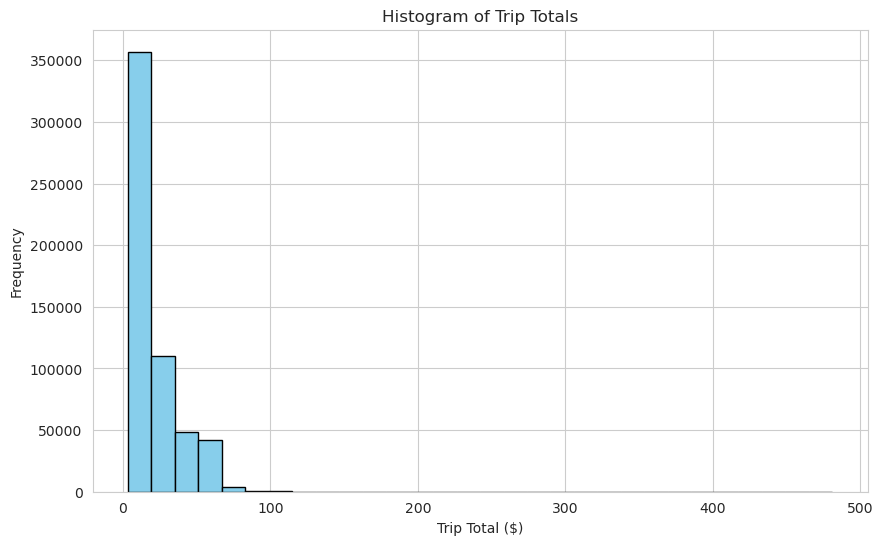

In [28]:
# Plot a histogram to observe the 'Trip_Total' column
plt.figure(figsize=(10, 6))  # Set the figure size
plt.hist(data['Trip_Total'], bins=30, color='skyblue', edgecolor='black')  # Set the number of bins and color
plt.title('Histogram of Trip Totals')  # Set the title of the plot
plt.xlabel('Trip Total ($)')  # Set the label for the x-axis
plt.ylabel('Frequency')  # Set the label for the y-axis
plt.grid(True)  # Add gridlines

# Show the plot
plt.show()

### 3.2.4 Data Plotting

After a thorough analysis and processing of the dataset, we now have a relatively high-quality taxi dataset. Therefore, we will select the columns to be analyzed next.

In [29]:
# Define the columns we want to keep
columns_to_keep = [
    'Trip_Seconds', 'Trip_Miles', 'days_from_base', 'hour', 'temp', 
    'feelslike', 'dew', 'humidity', 'precip', 'snow', 'snowdepth', 
    'windgust', 'windspeed', 'winddir', 'sealevelpressure', 
    'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex'
]

# Update data to only include these columns
data = data[columns_to_keep]

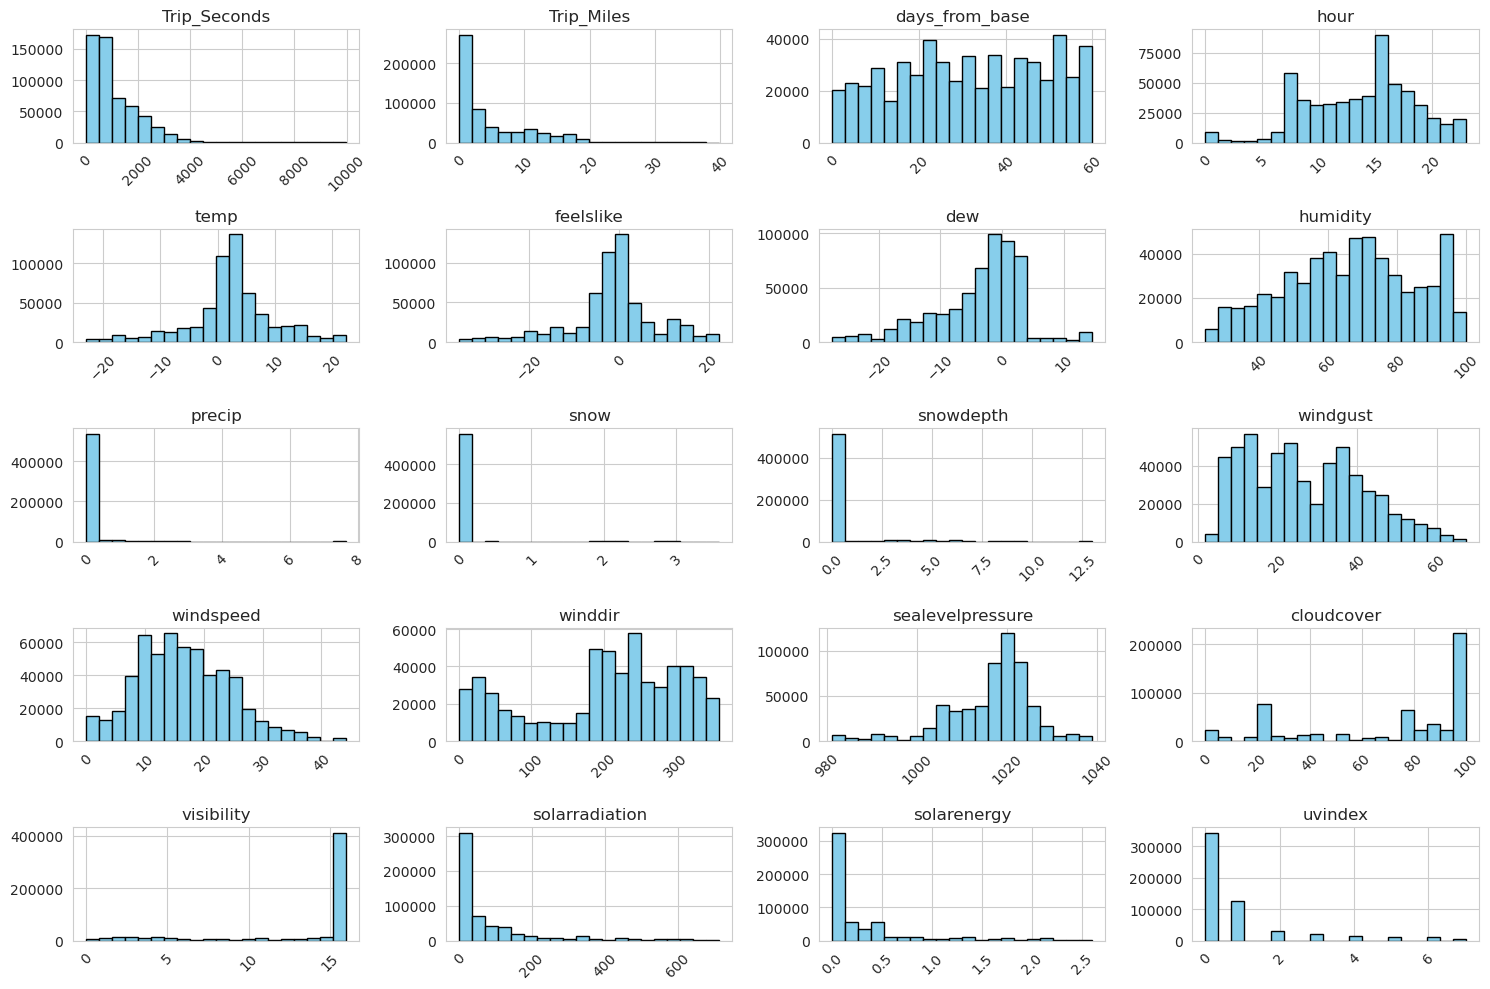

In [30]:
# Print data distribution

# Set canvas size
plt.figure(figsize=(15, 10))

# Plot histograms for each variable
for index, column in enumerate(columns_to_keep):
    plt.subplot(5, 4, index + 1)  # 5 rows and 4 columns grid, current index position
    plt.hist(data[column].dropna(), bins=20, color='skyblue', edgecolor='black')  # Use dropna() on each column to ensure NaN values are not counted
    plt.title(column)
    plt.xticks(rotation=45)  # Rotate X-axis labels for better display
    plt.tight_layout()  # Adjust the layout of each subplot

# Display the chart
plt.show()

# 4. Methodology

This study employs regression-based supervised machine learning techniques to analyse factors influencing taxi trip duration in Chicago. The data is divided into training and testing sets, and four modeling approaches are used:

- **Linear Regression**: Assesses linear relationships using Ordinary Least Squares (OLS).

- **ElasticNet Regression**: Combines Ridge and Lasso regression with L1 and L2 regularization, addressing multicollinearity and performing feature selection.

- **Random Forest**: Constructs decision trees to improve prediction accuracy and control overfitting, handling complex non-linear relationships without feature normalization.

- **XGBoost**: A gradient boosting algorithm insensitive to outliers, handling various data types and providing feature importance insights.

Model performance is evaluated using Root Mean Square Error (RMSE) and the coefficient of determination (R²). 

## 4.1 Linear Regression

### 4.1.1 Multicollinearity

We need to check the multicollinearity between variables by plotting correlation matrix before linear regression.

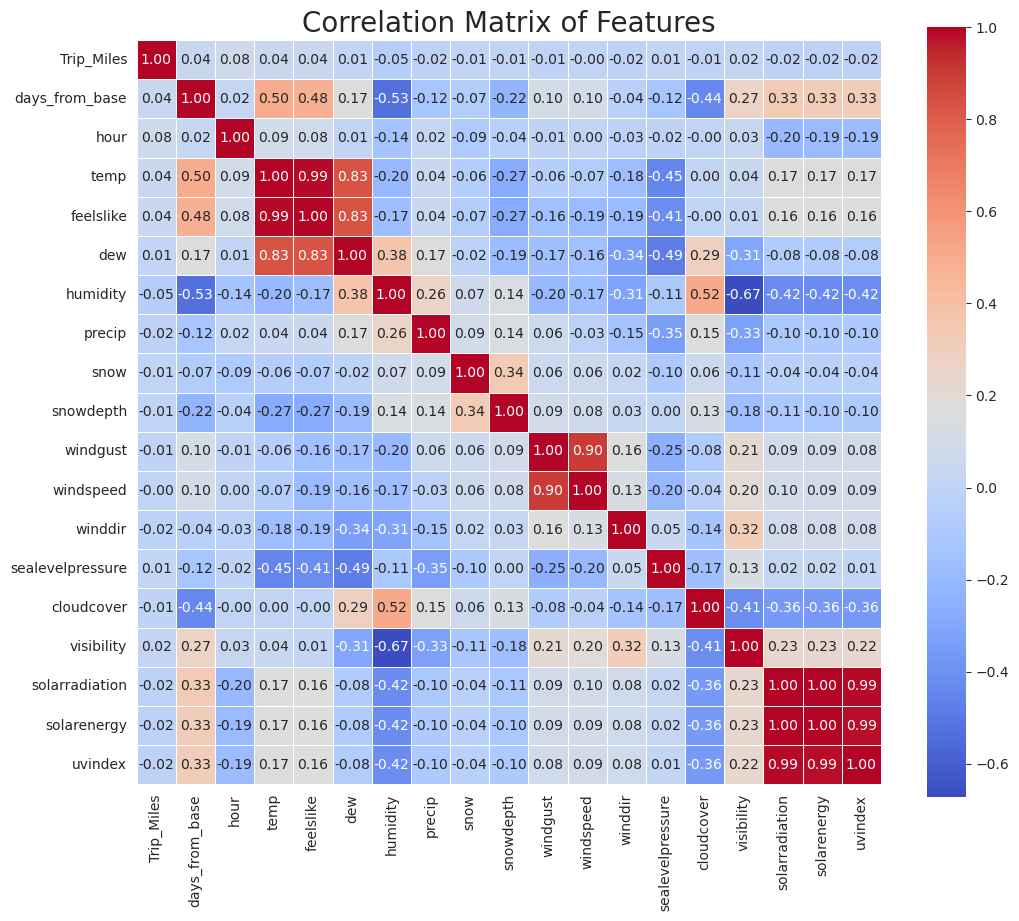

In [31]:
# Select columns other than 'Trip_Seconds' to compute the correlation matrix
features = data.drop(['Trip_Seconds'], axis=1)

# Calculate the correlation matrix
corr_matrix = features.corr()

# Use Seaborn to plot the correlation matrix
plt.figure(figsize=(12, 10))  # Set the size of the figure
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True,
            annot_kws={'size': 10}, linewidths=.5)
plt.title('Correlation Matrix of Features', fontsize=20)  # Add a title
plt.show()

The output shows that multicollinearity is common among the variables, so it must be addressed.

### 4.1.2 VIF

The standardised method to address multicollinearity involves the **Variance Inflation Factor (VIF)**. VIF quantifies how much the variance of an estimated regression coefficient increases when predictors are correlated, compared to when they are not correlated: 

$$\large VIF_j=\frac{1}{1-R_{j}^{2}}$$

VIFs start at 1 and have no upper limit, and values above 5 indicate severe multicollinearity, leading to unreliable coefficient estimates and p-values.

In [32]:
# calculating VIF
# This function is amended from: Practial 7, Data Science for Spatial Analysis, CASA 0006

def drop_column_using_vif_(df, list_var_not_to_remove=None, thresh=5):
    columns_to_drop = []
    
    while True:
        df_with_const = add_constant(df)
        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) for i in range(df_with_const.shape[1])], 
                           name="VIF", index=df_with_const.columns).to_frame()
        
        vif_df = vif_df.drop('const')
        
        if list_var_not_to_remove is not None:
            vif_df = vif_df.drop(list_var_not_to_remove)
        
        print('Max VIF:', vif_df.VIF.max())
        
        if vif_df.VIF.max() > thresh:
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            columns_to_drop.append(index_to_drop)
            df = df.drop(columns = index_to_drop)
        else:
            break
    
    print('Columns dropped:', columns_to_drop)
    return df

In [33]:
indepdent_variables = [
    'Trip_Miles', 'days_from_base', 'hour', 'temp', 
    'feelslike', 'dew', 'humidity', 'precip', 'snow', 'snowdepth', 
    'windgust', 'windspeed', 'winddir', 'sealevelpressure', 
    'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex'
]


vif = drop_column_using_vif_(data[indepdent_variables], thresh=5)
print("The columns remaining after VIF selection are:")
print(vif.columns)

Max VIF: 555.266696422574
Dropping: solarradiation
Max VIF: 257.41058978800544
Dropping: temp
Max VIF: 86.74383653432932
Dropping: dew
Max VIF: 37.143902008518246
Dropping: solarenergy
Max VIF: 5.628457372342426
Dropping: windgust
Max VIF: 3.1408074605063545
Columns dropped: ['solarradiation', 'temp', 'dew', 'solarenergy', 'windgust']
The columns remaining after VIF selection are:
Index(['Trip_Miles', 'days_from_base', 'hour', 'feelslike', 'humidity',
       'precip', 'snow', 'snowdepth', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'uvindex'],
      dtype='object')


In [34]:
vif.head()

,Trip_Miles,days_from_base,hour,feelslike,humidity,precip,snow,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,visibility,uvindex
1,3.00,60,0,-1.3,42.73,0.0,0.0,0.0,21.1,191,1025.3,0.0,16.0,0
3,13.36,60,0,-1.3,42.73,0.0,0.0,0.0,21.1,191,1025.3,0.0,16.0,0
4,6.13,60,0,-1.3,42.73,0.0,0.0,0.0,21.1,191,1025.3,0.0,16.0,0
6,11.17,60,0,-1.3,42.73,0.0,0.0,0.0,21.1,191,1025.3,0.0,16.0,0
8,12.52,60,0,-1.3,42.73,0.0,0.0,0.0,21.1,191,1025.3,0.0,16.0,0


### 4.1.3 OLS

In [35]:
# Split the data into features (X) and target (y)
X = vif.copy()  # Assuming 'vif' is the dataframe with the selected features
y = data['Trip_Seconds']  # Assuming 'Trip_Seconds' is the target variable

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [36]:
import statsmodels.api as sm

# Add a constant term to the model
X_with_constant = sm.add_constant(X) 

# Fit the model using OLS
model = sm.OLS(y, X_with_constant).fit() 

# Print the model summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           Trip_Seconds   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                 8.028e+04
Date:                Sun, 21 Apr 2024   Prob (F-statistic):               0.00
Time:                        12:58:33   Log-Likelihood:            -4.3075e+06
No. Observations:              561690   AIC:                         8.615e+06
Df Residuals:                  561675   BIC:                         8.615e+06
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const             -131.5653     99.427  

The model's output indicates an R-squared meaning that 66.7% of the variation in Trip Seconds can be explained by the independent variables in the model. Moreover, all the variables we studied have p-values less than the significance level of 0.05, indicating that after VIF, the variables in our dataset are statistically significant.

### 4.1.4 Residuals Analysis

Residuals represent the differences between observed values and model-predicted values. Ideally, the Residuals vs Fitted Values Plot should be distributed around 0 with no significant trends, meanwhile, points on the QQ plot should roughly follow a straight line, indicating that the residuals are normally distributed.

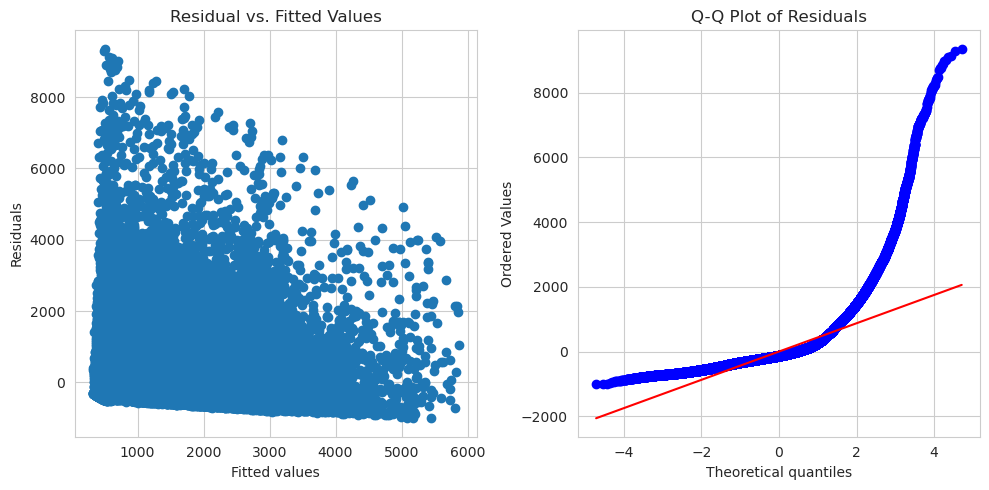

In [37]:
# Calculate residuals
residuals = model.resid

# Plot residuals vs. predicted values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(model.fittedvalues, residuals)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residual vs. Fitted Values')

# Plot QQ plot of residuals
plt.subplot(1, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

We found that the residuals are not randomly distributed, and the QQ-plot does not mainly lie on the line, which indicates that the model's assumptions is not conform to the authentic distribution of the data.

## 4.2 ElasticNet Regression

In [38]:
# Data type adjustment

# Convert X and y to float32 type
X_float = X.astype('float32') 
y_float = y.astype('float32')  

# Convert the Pandas DataFrame to a cuDF DataFrame
X_cudf = cudf.DataFrame.from_pandas(X_float) 

# Convert the Pandas Series to a cuDF Series
y_cudf = cudf.Series(y_float.to_numpy())      

In [39]:
# Split the data into training and testing sets
X_train_en, X_test_en, y_train_en, y_test_en = train_test_split(X_cudf, y_cudf, test_size=0.3, random_state=42)

# Define the ElasticNet regression model
en = ElasticNet()

# Define the hyperparameter grid
param_grid = {
    'alpha': [0.1, 0.5, 1],
    'l1_ratio': [0.1, 0.2, 0.5],
    'max_iter': [1000, 5000],
    'tol': [0.001, 0.0001]
}

# Create a GridSearchCV object
grid_search_en = GridSearchCV(estimator=en, param_grid=param_grid, cv=3)  # Using 3-fold cross-validation

# Perform grid search
grid_search_en.fit(X_train_en, y_train_en)

# Output the best model and parameters
print("Best model:", grid_search_en.best_estimator_)
print("Best parameters:", grid_search_en.best_params_)

Best model: ElasticNet()
Best parameters: {'alpha': 0.1, 'l1_ratio': 0.5, 'max_iter': 1000, 'tol': 0.0001}


In [40]:
# Use the best model for prediction
best_model_en = grid_search_en.best_estimator_
y_pred_train_en = best_model_en.predict(X_train_en)
y_pred_test_en = best_model_en.predict(X_test_en)

# Calculate and print the R2 score and RMSE
print("R2 on the training data:")
print(r2_score(y_train_en, y_pred_train_en))
print("R2 on the testing data:")
print(r2_score(y_test_en, y_pred_test_en))

print("RMSE on the training data:")
print(mean_squared_error(y_train_en, y_pred_train_en, squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(y_test_en, y_pred_test_en, squared=False))

R2 on the training data:
0.6674140691757202
R2 on the testing data:
0.6652576327323914
RMSE on the training data:
517.00775
RMSE on the testing data:
520.21704


## 4.3 Random Forest

In [41]:
# Split the data into training and testing sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_cudf, y_cudf, test_size=0.3, random_state=42)

# Define the RandomForestRegressor model
rf = RandomForestRegressor(random_state=42, n_streams=1)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [3, 5],
}

# Create GridSearchCV object
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3)  # Use 3 folds for quicker runs

# Execute grid search
grid_search_rf.fit(X_train_rf, y_train_rf)

# Output best model and parameters
print("Best model:", grid_search_rf.best_estimator_)
print("Best parameters:", grid_search_rf.best_params_)

Best model: RandomForestRegressor()
Best parameters: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 150}


In [42]:
# Use the best model for prediction
best_model_rf = grid_search_rf.best_estimator_
y_pred_train_rf = best_model_rf.predict(X_train_rf)
y_pred_test_rf = best_model_rf.predict(X_test_rf)

# Calculate and print the R2 score and RMSE
print("R2 on the training data:")
print(r2_score(y_train_rf, y_pred_train_rf))
print("R2 on the testing data:")
print(r2_score(y_test_rf, y_pred_test_rf))

print("RMSE on the training data:")
print(mean_squared_error(y_train_rf, y_pred_train_rf, squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(y_test_rf, y_pred_test_rf, squared=False))

R2 on the training data:
0.6728696823120117
R2 on the testing data:
0.6705631017684937
RMSE on the training data:
512.7498
RMSE on the testing data:
516.078


## 4.4 XGBoost

In [43]:
# Split the data into training and testing sets
X_train_xgb, X_test_xgb, y_train_xgb, y_test_xgb = sk_train_test_split(X_float, y_float, test_size=0.3, random_state=42)

# Initialize the XGBoost model
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the hyperparameter grid
param_grid_xgb = {
    'n_estimators': [100, 200],  # Number of trees in the forest
    'max_depth': [10, 20],  # The maximum depth of a tree
    'colsample_bytree': [0.3, 0.5],  # The subsample ratio of features when constructing each tree
    'learning_rate': [0.05, 0.1]  # The step size shrinkage used in update to prevent overfitting
}

# Use GridSearchCV for hyperparameter optimization with 3-fold cross-validation
grid_search_xgb = sk_GridSearchCV(xgb, param_grid_xgb, cv=3, scoring='r2', verbose=1)

# Fit the GridSearchCV object using the training dataset
grid_search_xgb.fit(X_train_xgb, y_train_xgb)

# Print the best parameter values
print("The best parameter values are:")
print(grid_search_xgb.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
The best parameter values are:
{'colsample_bytree': 0.5, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 200}


In [44]:
# Use the best model for prediction
best_model_xgb = grid_search_xgb.best_estimator_
y_pred_train_xgb = best_model_xgb.predict(X_train_xgb)
y_pred_test_xgb = best_model_xgb.predict(X_test_xgb)

# Calculate and print the R2 score and RMSE
print("R2 on the training data:")
print(r2_score(y_train_xgb, y_pred_train_xgb))
print("R2 on the testing data:")
print(r2_score(y_test_xgb, y_pred_test_xgb))

print("RMSE on the training data:")
print(mean_squared_error(y_train_xgb, y_pred_train_xgb, squared=False))
print("RMSE on the testing data:")
print(mean_squared_error(y_test_xgb, y_pred_test_xgb, squared=False))

R2 on the training data:
0.7425426244735718
R2 on the testing data:
0.7151339054107666
RMSE on the training data:
455.25916
RMSE on the testing data:
478.97235


# 5. Results

## 5.1 Feature Importance

#### Linear Regression

The residual analysis of Linear Regression shows that linear regression may have bias or not satisfy the model assumptions, thus the reliability of its results is questionable. Therefore, we only compare the other three models.

#### ElasticNet Regression

In [45]:
# Convert column names to a NumPy array
feature_names = X_train_en.columns.to_numpy()

# Extract coefficients of the best model
coefficients = best_model_en.coef_

# Create pairs of features and their coefficients, then sort by the absolute value of the coefficients
features_importance = cudf.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
features_importance['Abs_Coefficient'] = features_importance['Coefficient'].abs()
features_en = features_importance.sort_values(by='Abs_Coefficient', ascending=False)

#### Random Forest

In [46]:
# cuML currently does not support feature importance, convert the cuML model to a scikit-learn model
best_model_rf_skl = sklRandomForestRegressor()
best_model_rf_skl.n_estimators = best_model_rf.n_estimators
best_model_rf_skl.max_depth = best_model_rf.max_depth
best_model_rf_skl.min_samples_split = best_model_rf.min_samples_split
best_model_rf_skl.min_samples_leaf = best_model_rf.min_samples_leaf
best_model_rf_skl.fit(X_train_rf.to_pandas(), y_train_rf.to_pandas())

# Get feature importance
feature_importances = best_model_rf_skl.feature_importances_

# Pair feature importance with feature names
feature_importance_dict = dict(zip(X_train_rf.to_pandas().columns, feature_importances))

# Sort by feature importance in descending order
features_rf = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

#### XGBoost

In [47]:
# Retrieve feature importance
importances = best_model_xgb.feature_importances_

# Indices sorted in descending order by importance
sorted_indices = importances.argsort()[::-1]

# Feature names sorted in descending order by importance
feature_names = X.columns  # Assuming X is your feature matrix
sorted_feature_names = feature_names[sorted_indices]

# Create a DataFrame containing feature names and their corresponding importance
features_xgb = pd.DataFrame({'feature': sorted_feature_names, 'importance': importances[sorted_indices]})

#### Output Feature Importances

In [48]:
# Convert features_rf into a DataFrame
features_rf_df = pd.DataFrame(features_rf, columns=['Feature', 'Importance'])

# Rename columns to differentiate between models
features_en = features_en.rename(columns={'Abs_Coefficient': 'ElasticNet'})
features_rf_df = features_rf_df.rename(columns={'Importance': 'RandomForest'})
features_xgb = features_xgb.rename(columns={'importance': 'XGBoost'})

# Create a DataFrame for ElasticNet
elastic_features = pd.DataFrame({'Feature': features_en['Feature'], 'ElasticNet': features_en['ElasticNet']})

# Create a DataFrame for Random Forest
rf_features = pd.DataFrame({'Feature': features_rf_df['Feature'], 'RandomForest': features_rf_df['RandomForest']})

# Create a DataFrame for XGBoost
xgb_features = pd.DataFrame({'Feature': features_xgb['feature'], 'XGBoost': features_xgb['XGBoost']})

# Store DataFrames in a dictionary
model_features = {
    'ElasticNet': elastic_features,
    'RandomForest': rf_features,
    'XGBoost': xgb_features
}

# Print feature importances for each model
for model, features in model_features.items():
    print(f"{model} Feature Importances:")
    print(features)
    print()

ElasticNet Feature Importances:
             Feature  ElasticNet
0         Trip_Miles  136.004120
13           uvindex    9.553869
6               snow    8.491669
5             precip    5.871501
12        visibility    5.102377
2               hour    3.396005
7          snowdepth    1.953390
3          feelslike    1.328818
4           humidity    1.191724
8          windspeed    0.822782
10  sealevelpressure    0.762399
1     days_from_base    0.270490
11        cloudcover    0.223553
9            winddir    0.084059

RandomForest Feature Importances:
             Feature  RandomForest
0         Trip_Miles  9.909205e-01
1               hour  9.075774e-03
2         visibility  3.159943e-06
3   sealevelpressure  3.512359e-07
4          feelslike  1.726199e-07
5     days_from_base  0.000000e+00
6           humidity  0.000000e+00
7             precip  0.000000e+00
8               snow  0.000000e+00
9          snowdepth  0.000000e+00
10         windspeed  0.000000e+00
11           windd

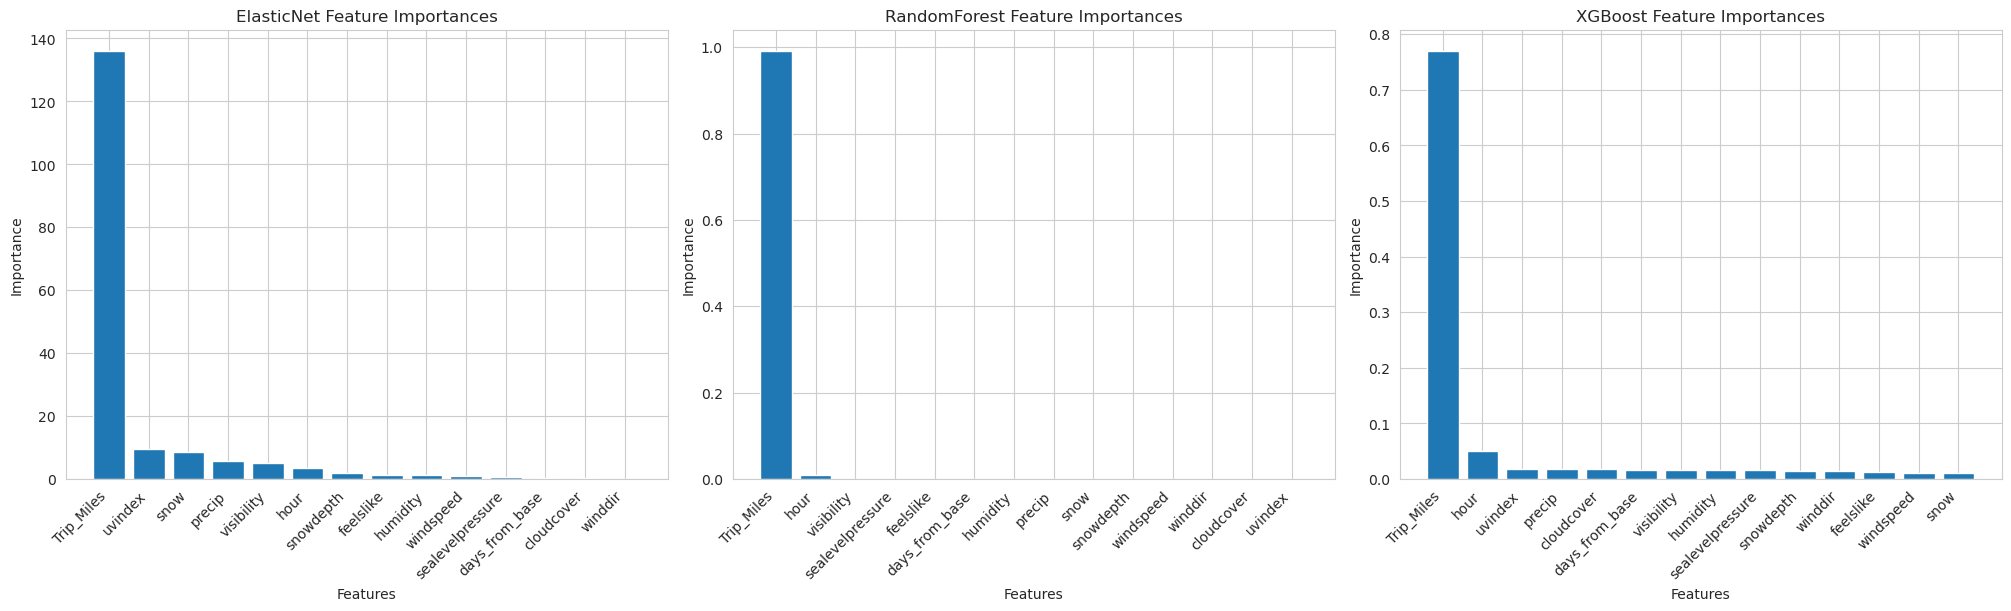

In [49]:
# Plot the feature importances bar chart for each model
fig, axs = plt.subplots(1, 3, figsize=(20, 6), constrained_layout=True)  # Use constrained_layout to automatically adjust the layout
for i, (model, features) in enumerate(model_features.items()):
    bars = axs[i].bar(features['Feature'], features.iloc[:, 1])
    axs[i].set_title(f"{model} Feature Importances")
    axs[i].set_xlabel("Features")
    axs[i].set_ylabel("Importance")
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].set_xticks([r for r, _ in enumerate(features['Feature'])])
    axs[i].set_xticklabels(features['Feature'], ha='right', rotation=45)  # Adjust label alignment

plt.show()


From the comparison of feature importance across the three models, the most important feature in all three models is Trip_Miles, which far surpasses other features and represents the length of the trip. This is particularly prominent in Random Forest, accounting for 99.1%. For ElasticNet Regression, UV index, snow depth, precipitation, visibility, and hour of the day, are all relatively significant features. Apart from Trip_Miles, the top-ranking significant features in XGBoost represent the hour of the day, UV intensity and precipitation.

## 5.2 Comparison of models

In [50]:
# Define model names
models = ['ElasticNet', 'Random Forest', 'XGBoost']

# Calculate R2 and RMSE
r2_train = [r2_score(y_train_en, y_pred_train_en),
            r2_score(y_train_rf, y_pred_train_rf),
            r2_score(y_train_xgb, y_pred_train_xgb)]

r2_test = [r2_score(y_test_en, y_pred_test_en),
           r2_score(y_test_rf, y_pred_test_rf),
           r2_score(y_test_xgb, y_pred_test_xgb)]

rmse_train = [mean_squared_error(y_train_en, y_pred_train_en, squared=False),
              mean_squared_error(y_train_rf, y_pred_train_rf, squared=False),
              mean_squared_error(y_train_xgb, y_pred_train_xgb, squared=False)]

rmse_test = [mean_squared_error(y_test_en, y_pred_test_en, squared=False),
             mean_squared_error(y_test_rf, y_pred_test_rf, squared=False),
             mean_squared_error(y_test_xgb, y_pred_test_xgb, squared=False)]

# Convert CuPy arrays to NumPy arrays
r2_train = cp.array(r2_train).get()
r2_test = cp.array(r2_test).get()
rmse_train = cp.array(rmse_train).get()
rmse_test = cp.array(rmse_test).get()

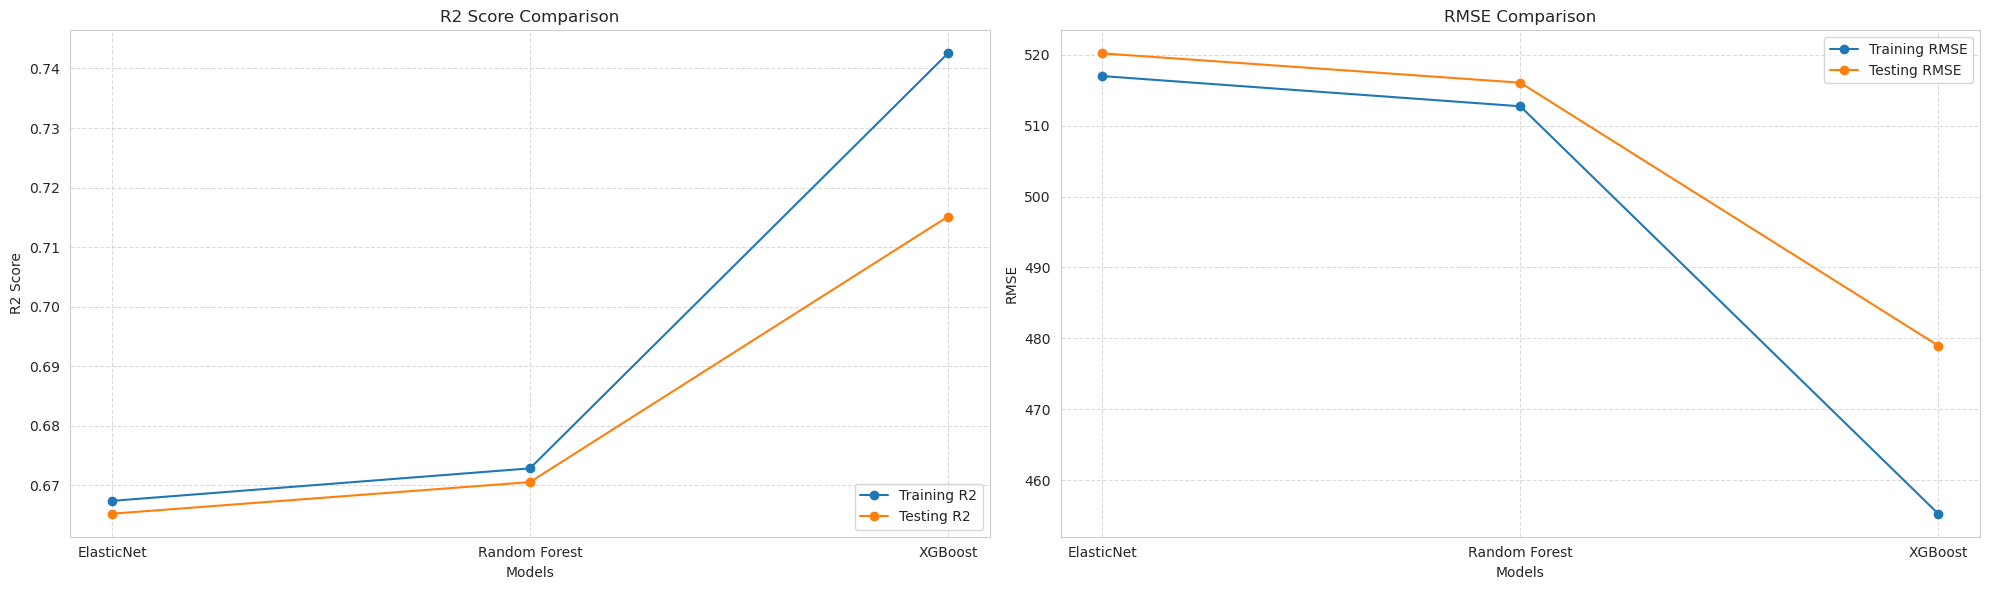

In [51]:
# Create a subplot with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

# Plot the R2 Score figure
x = range(len(models))
axs[0].plot(x, r2_train, marker='o', label='Training R2')
axs[0].plot(x, r2_test, marker='o', label='Testing R2')
axs[0].set_xlabel('Models')
axs[0].set_ylabel('R2 Score')
axs[0].set_title('R2 Score Comparison')
axs[0].set_xticks(x)
axs[0].set_xticklabels(models)
axs[0].legend(loc='lower right')
axs[0].grid(True, linestyle='--', alpha=0.7)

# Plot the RMSE figure
axs[1].plot(x, rmse_train, marker='o', label='Training RMSE')
axs[1].plot(x, rmse_test, marker='o', label='Testing RMSE')
axs[1].set_xlabel('Models')
axs[1].set_ylabel('RMSE')
axs[1].set_title('RMSE Comparison')
axs[1].set_xticks(x)
axs[1].set_xticklabels(models)
axs[1].legend(loc='upper right')
axs[1].grid(True, linestyle='--', alpha=0.7)

# Automatically adjust the layout to prevent overlap
plt.tight_layout()
plt.show()

By comparing the R-squared and RMSE of ElasticNet Regression, Random Forest, and XGBoost, we can see that the R-squared of XGBoost is higher than ElasticNet Regression and Random Forest on both the training dataset and the test dataset, while its RMSE is lower than theirs. This indicates that the XGBoost model performs the best.

# 6. Discussion

Apart from Linear Regression, the analysis of the other three methods shows that although XGBoost has slight overfitting compared to the other two models, its model performance is still the best, with the highest R-squared (training data: 0.74254, testing data: 0.71513) and the lowest RMSE (training data: 455.25916, testing data: 478.97235). Meanwhile, the RMSE of the three machine learning methods is around 500, and although the range of Trip Seconds is between 0 and 20000, there is still considerable room for improvement. This is probably because trip duration is affected by many factors (Sakhare et al., 2023). Considering the impact of factors such as traffic, even with the same Trip Miles under the same weather conditions, there may be significant differences due to pick-up and drop-off locations, route choice or emergencies in the city. Moreover, in the future, we need to consider geographical factors, including trip route, distribution of transportation road networks, and commuting flow combined with time. These measures are expected to effectively improve R-squared and reduce RMSE. The analysis of feature importance in XGBoost shows that Trip Seconds is greatly influenced by Trip Miles, and combining weather data can better predict trip duration and improve the model's accuracy. Interestingly, as shown in the feature importance of weather, UV intensity have impact on trip duration, which worth further exploration.

Furthermore, we used GPU acceleration to train the ElasticNet Regression and Random Forest models, significantly reducing the training time of our machine learning models compared to CPU training. It provides a reference for future governments, taxi companies, or researchers who want to more efficiently predict trip duration using machine learning over a larger spatial range, longer time dimensions, and incorporating traffic and geographical factors beyond Chicago.

# 7. Conclusion

This study utilises taxi and weather data from Chicago and discovers that by combining key factors such as trip distance, hour, UV index, and precipitation, the XGBoost model can effectively predict taxi trip duration. By incorporating more relevant factors and increasing the amount of data, the model's prediction accuracy is expected to be further improved in the future. This research also demonstrates how to leverage advanced techniques and hardware acceleration methods to achieve efficient and accurate transportation modeling, providing insights for taxi fleet management and transportation planning.

# References

Changnon, S. A. (1996). ‘Effects of summer precipitation on urban transportation’. Climatic Change, 32 (4), pp. 481–494. doi: 10.1007/BF00140357.

‘chicagotaxiplacard20200629.pdf’. (no date). Available at: https://www.chicago.gov/content/dam/city/depts/bacp/publicvehicleinfo/Chicabs/chicagotaxiplacard20200629.pdf (Accessed: 17 April 2024).

Chmielewski, J. and Budzynski, M. (2019). ‘The Impact of Weather on Traffic Speed in Urban Area’. IOP Conference Series: Materials Science and Engineering. IOP Publishing, 603 (2), p. 022072. doi: 10.1088/1757-899X/603/2/022072.
Kamga, C., Yazici, M. A. and Singhal, A. (2013). ‘Hailing in the Rain: Temporal and Weather-Related Variations in Taxi Ridership and Taxi Demand-Supply Equilibrium’.

Kamga, C., Yazici, M. A. and Singhal, A. (2013). ‘Hailing in the Rain: Temporal and Weather-Related Variations in Taxi Ridership and Taxi Demand-Supply Equilibrium’

Koetse, M. J. and Rietveld, P. (2009). ‘The impact of climate change and weather on transport: An overview of empirical findings’. Transportation Research Part D: Transport and Environment, 14 (3), pp. 205–221. doi: 10.1016/j.trd.2008.12.004.

Learn More | RAPIDS. (no date). RAPIDS | GPU Accelerated Data Science. Available at: https://rapids.ai/learn-more/ (Accessed: 16 April 2024).

Poongodi, M., Malviya, M., Kumar, C., Hamdi, M., Vijayakumar, V., Nebhen, J. and Alyamani, H. (2022). ‘New York City taxi trip duration prediction using MLP and XGBoost’. International Journal of System Assurance Engineering and Management, 13 (1), pp. 16–27. doi: 10.1007/s13198-021-01130-x.

Sakhare, R. S., Zhang, Y., Li, H. and Bullock, D. M. (2023). ‘Impact of Rain Intensity on Interstate Traffic Speeds Using Connected Vehicle Data’. Vehicles. Multidisciplinary Digital Publishing Institute, 5 (1), pp. 133–155. doi: 10.3390/vehicles5010009.

Sun, J., Dong, H., Qin, G. and Tian, Y. (2020). ‘Quantifying the Impact of Rainfall on Taxi Hailing and Operation’. Journal of Advanced Transportation. Hindawi, 2020, p. e7081628. doi: 10.1155/2020/7081628.

Traffic and Safety. (no date). Available at: https://www.isp.illinois.gov/TrafficSafety/SpeedLimitEnforcement (Accessed: 17 April 2024).

Zhang, J., Song, G., Gong, D., Gao, Y., Yu, L. and Guo, J. (2018). ‘Analysis of rainfall effects on road travel speed in Beijing, China’. IET Intelligent Transport Systems, 12 (2), pp. 93–102. doi: 10.1049/iet-its.2017.0039.

